# LangGraph/LiteLLM Application with Tool (Travily)

In [5]:
import os
import json
import logging
import operator
import random
import string
from typing import (
    Annotated, List, Dict, TypedDict, Callable, Union, Literal, Optional, Any
)

from pydantic import (
    BaseModel,
    Field,
    ConfigDict,
    field_validator
)

from litellm import completion
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command

import sqlite3
from tavily import TavilyClient

from IPython.display import Image, display

# Model

In [2]:
path_to_openai_key:str = os.path.expanduser('~/.openai/api_key')
with open(path_to_openai_key, 'r', encoding='utf-8') as file:
    os.environ["OPENAI_API_KEY"] = file.read().strip()

MODEL: str = "openai/gpt-4o"

## Completion Model

LiteLLM uses Open AI input format as the standardised schema.

* [completion - Input Params](https://docs.litellm.ai/docs/completion/input)

> LiteLLM accepts and translates the OpenAI Chat Completion params across all providers.

See the OpenAI document for the available options.

* [OpenAI API - Chat Completion](https://platform.openai.com/docs/api-reference/chat/create)



### Prompt

In [3]:
system_message = """
You are a helpful assistant to help autonomous task-execution agents.

PRIMARY ROLE
- Transform user queires into explicit, executable plans or tool calls.
- Be meticulously step by step to derive the plans or tool calls.
- Execute only steps that are logically justified and safe.
- Prefer correctness and completeness over speed.
- Think deeper and validate the thought processes taken.

OPERATING RULES
1. Never assume missing information.
2. If required information is missing, explicitly ask for it.
3. Do not invent facts, APIs, files, or system state.
4. If a task exceeds your authority or tools, stop and report.
5. If the query is unethical or can violate regulations or laws, stop and report.

REASONING
- Break tasks into explicit substeps.
- Validate each step before proceeding.
- Track assumptions explicitly.
- Detect contradictions and stop if found.|

TOOL USAGE
- Use tools when you cannot handle by yourself.
- Do not call tools speculatively.
- Validate tool outputs before using them downstream.

OUTPUT CONTRACT
- Produce outputs that are:
  - deterministic
  - reproducible
  - minimal but sufficient
- Clearly separate:
  - conclusions
  - assumptions
  - open questions

FAILURE MODE
- When uncertain, return:
  "Cannot proceed safely due to missing or conflicting information."
- Never guess.
"""

user_message:str = "When QF26 departs today?"

## Model Query without Tools

LLM does not know how to get NYC time.

In [4]:
response = completion(
    model=MODEL,
    messages=[
      {
        "role": "system",
        "content": system_message
      },
      {
        "role": "user",
        "content": user_message
      }
    ],
    temperature=1.0,
    max_tokens=120,
    tool_choice=None,
)

In [5]:
print(json.dumps(response.model_dump(), indent=2))

{
  "id": "chatcmpl-CqCry5pajKWSqnBz58ytZAnT55oZX",
  "created": 1766558562,
  "model": "gpt-4o-2024-08-06",
  "object": "chat.completion",
  "system_fingerprint": "fp_deacdd5f6f",
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "To determine the departure time for QF26 today, I would typically need to access real-time flight status information. However, I don't have built-in tools to access real-time data or external systems directly. To proceed, you can check the flight status on the airline's official website, use a flight-tracking app, or contact the airline for the most accurate and up-to-date information.",
        "role": "assistant",
        "tool_calls": null,
        "function_call": null,
        "provider_specific_fields": {
          "refusal": null
        },
        "annotations": []
      },
      "provider_specific_fields": {}
    }
  ],
  "usage": {
    "completion_tokens": 78,
    "prompt_tokens": 298,
    "

---
# Tools

## Defining Tool Schema

Suppose using [Tavily - Search](https://docs.tavily.com/sdk/python/reference#tavily-search) as a general search tool such as getting time or weather of a city. We need to tell LLM of the schema that Tavily Search accepts. Find the available parameters from the API document or using [Tavily Search Playground](https://app.tavily.com/home). Then LiteLLM can get the Tool Schema from SearchTool.model_json_schema()

In [6]:
class SearchTool(BaseModel):
    # DocString tells LLM what this tool is for.
    """Search the web for general topics such as time, news, weather, events."""
    query: str = Field(description="The search query to look up")

    #--------------------------------------------------------------------------------
    # Attributes of Tavily Search API (https://docs.tavily.com/sdk/python/reference).
    # LLM can genrate the arguments based on these information.
    #--------------------------------------------------------------------------------
    topic: Literal["general", "news", "finance"] = Field(
        default="general",
        description="Category of search. Use 'news' for current events/politics, 'finance' for market data."
    )
    
    search_depth: Literal["basic", "advanced"] = Field(
        default="basic",
        description="Use 'basic' for quick facts. Use 'advanced' for complex queries needing more context."
    )
    
    time_range: Optional[Literal["day", "week", "month", "year"]] = Field(
        default=None,
        description="Filter results by publication date. Especially useful with topic='news'."
    )
    
    max_results: int = Field(
        default=5, ge=1, le=10,
        description="Number of search results to return."
    )

In [7]:
print(json.dumps(SearchTool.model_json_schema(), indent=2))

{
  "description": "Search the web for general topics such as time, news, weather, events.",
  "properties": {
    "query": {
      "description": "The search query to look up",
      "title": "Query",
      "type": "string"
    },
    "topic": {
      "default": "general",
      "description": "Category of search. Use 'news' for current events/politics, 'finance' for market data.",
      "enum": [
        "general",
        "news",
        "finance"
      ],
      "title": "Topic",
      "type": "string"
    },
    "search_depth": {
      "default": "basic",
      "description": "Use 'basic' for quick facts. Use 'advanced' for complex queries needing more context.",
      "enum": [
        "basic",
        "advanced"
      ],
      "title": "Search Depth",
      "type": "string"
    },
    "time_range": {
      "anyOf": [
        {
          "enum": [
            "day",
            "week",
            "month",
            "year"
          ],
          "type": "string"
        },
     

## Model Query with Tools

In [8]:
response = completion(
    model=MODEL,
    messages=[
      {
        "role": "system",
        "content": system_message
      },
      {
        "role": "user",
        "content": user_message
      }
    ],
    temperature=1.0,
    max_tokens=120,
    # --------------------------------------------------------------------------------
    # Provide Tools
    # --------------------------------------------------------------------------------
    tool_choice="auto",
    tools = [{
        "type": "function",
        "function": {
            "name": SearchTool.__name__,
            "description": SearchTool.__doc__,
            "parameters": SearchTool.model_json_schema()
        }
    }]
)

In [9]:
print(json.dumps(response.model_dump(), indent=2))

{
  "id": "chatcmpl-CqCs0ePKMqFX5j3GT76nEv5Ng5m9a",
  "created": 1766558564,
  "model": "gpt-4o-2024-08-06",
  "object": "chat.completion",
  "system_fingerprint": "fp_deacdd5f6f",
  "choices": [
    {
      "finish_reason": "tool_calls",
      "index": 0,
      "message": {
        "content": null,
        "role": "assistant",
        "tool_calls": [
          {
            "function": {
              "arguments": "{\"query\":\"QF26 flight departure time October 16, 2023\",\"topic\":\"general\",\"search_depth\":\"basic\",\"time_range\":\"day\"}",
              "name": "SearchTool"
            },
            "id": "call_hV9wJwgJzFPVg30cVmMg7CXn",
            "type": "function"
          }
        ],
        "function_call": null,
        "provider_specific_fields": {
          "refusal": null
        },
        "annotations": []
      },
      "provider_specific_fields": {}
    }
  ],
  "usage": {
    "completion_tokens": 40,
    "prompt_tokens": 531,
    "total_tokens": 571,
    "comp

In [10]:
del response

---

# Application

## Tools

In [11]:
path_to_tavily_key:str = os.path.expanduser('~/.tavily/api_key')
with open(path_to_tavily_key, 'r', encoding='utf-8') as file:
    os.environ["TAVILY_API_KEY"] = file.read().strip()

tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [88]:
class State(BaseModel):
    """Represents the shared state of the LangGraph application.
    Attributes:
        request: The user's input string.
        response: The dictionary containing LLM completion data.
        message: The final string to be printed or shared between nodes.
        max_results: The upper limit for search results per query.
    """
    model_config = ConfigDict(frozen=True)

    request: str = Field(default="INITIAL_DO_NOT_SEE_THIS")
    response: Dict[str, Any] = Field(default_factory=dict)
    message: str = Field(default="")
    max_results: int = Field(
        default=5,
        description="The maximum number of results to fetch in a single search.",
    )

    @field_validator("max_results")
    @classmethod
    def validate_max_results(cls, v: int) -> int:
        """Validates that max_results is within the allowed range [1, 10].

        Args:
            v: The integer value for max_results to validate.

        Returns:
            The validated integer value.

        Raises:
            ValueError: If v is not between 1 and 10.
        """
        if v < 1 or v > 10:
            raise ValueError("max_results must be between 1 and 10")
        return v

class Agent:
    def __init__(
        self,
        model:str,
        system_message: str = ""
        tools: List[Dict[Any, Any]] = []
        id: Optional[str] = None,
        path_to_state_persistency: str = "checkpoints.db",
    ):
        """
        Args:
            model: Name of the LLM model
            system_message: LLM system prompt message
            tools: List of tool schemas accordinig to the OpenAI format
            path_to_state_persistency: path to the LangGraph state storage.
            id: LangGraph thread/session id
        """
        self.id = ''.join(random.choices(string.ascii_letters + string.digits, k=8)) if not id else id
        self.system_message = system_message
        self.model = model

        # ----------------------------------------------------------------------
        # Tools and their schemas to inform to LLM according to OpenAI format
        # as LiteLLM follows OpenAI standards. Each tool schema has the format:
        # ----------------------------------------------------------------------
        # {
        #     "type": "function",
        #     "function": {
        #         "name": <name of the tool>,
        #         "description": "<description of the tool e.g. function docstring>",
        #         "parameters": <"avilable parameters of the tool invocation">
        #     }
        # }
        # ----------------------------------------------------------------------        
        self.tool_schemas: List[Dict[Any, Any]] = [
            {
                 "type": "function",
                 "function": {
                     "name": k.__name__,
                     "description": k.__doc__,
                     "parameters": k.model_json_schema(),
                 },
             }
            for d in tools for k in d.keys()
        ]
        self.tool_names: List[str] = [
            k.__name__ for d in tools for k in d.keys()
        ]
        self.tools: List[Callable] = [
            v for d in tools for v in d.values()
        ]
        self.name_to_tool: Dict[str, Callable] = {
            _name: _tool for _name, _tool in zip(self.tool_names, self.tools)
        }
        
        # Initialize connection and saver internally to manage lifecycle
        self.path_to_state_persistency = path_to_state_persistency
        self.conn = sqlite3.connect(path_to_state_persistency, check_same_thread=False)
        self.checkpointer = SqliteSaver(self.conn)
        
        # Build Graph
        graph: StateGraph = StateGraph(State)

        graph.add_node("get_request", self.get_request)
        graph.add_edge("get_request", "call_llm")
        
        graph.add_node("call_llm", self.call_llm)
        graph.add_conditional_edges("call_llm", self.router)
        
        graph.add_node("call_tool", self.call_tool)
        graph.add_node("llm_answer", self.llm_answer)
        graph.add_node("report", self.report)
        graph.add_edge("llm_answer", "report")
        graph.add_edge("call_tool", "report")
        
        graph.add_edge("report", "get_request")
        graph.set_entry_point("get_request")

        # LangGraph Application
        self.application = graph.compile(checkpointer=self.checkpointer)

    def get_application(self) -> StateGraph:
        return self.application
    
    def get_request(self, state: State) -> Dict[str, Any]:
        """Prompts the user for their request via standard input.
    
        Args:
            state: The current shared state.
    
        Returns:
            A dictionary containing the updated request string.
        """
        print("-" * 100)
        user_input = input("What do you need? (Type 'exit' to stop): ").strip()
        return {"request": user_input}
    
    
    def call_llm(self, state: State) -> Dict[str, Any] | Command:
        """Calls the LLM with the current state request and available tools.
    
        Args:
            state: The current shared state containing the request string.
    
        Returns:
            A dictionary containing the LLM response object or an error status.
        """
        if not state.request.strip() or state.request == "INITIAL_DO_NOT_SEE_THIS":
            logging.error("state has invalid request:[%s]]", state.request)
            return {"request": "INVALID"}
    
        if state.request.lower() == "exit":
            return Command(graph=None, goto=END, update={"request": "EXIT", "response": {}})
    
        try:
            # --------------------------------------------------------------------------------
            # LiteLLM follows the OpenAI standard format.
            # --------------------------------------------------------------------------------
            # response = completion(
            #     model=MODEL,
            #     messages=[
            #       {
            #         "role": "system",
            #         "content": system_message
            #       },
            #       {
            #         "role": "user",
            #         "content": user_message
            #       }
            #     ],
            #     temperature=1.0,
            #     max_tokens=120,
            #     tool_choice="auto",
            #     # ----------------------------------------------------------------------
            #     # List of tools and their schemas to inform to LLM.
            #     # ----------------------------------------------------------------------
            #     tools = [{
            #         "type": "function",
            #         "function": {
            #             "name": SearchTool.__name__,
            #             "description": SearchTool.__doc__,
            #             "parameters": SearchTool.model_json_schema()
            #         }
            #     }]
            # )
            # --------------------------------------------------------------------------------
            response = completion(
                model=self.model,
                messages=[
                    {"role": "system", "content": self.system_message},
                    {"role": "user", "content": state.request},
                ],
                temperature=1.0,
                max_tokens=120,
                tool_choice="auto",
                tools=self.tool_schemas
                # tools=[
                #     {
                #         "type": "function",
                #         "function": {
                #             "name": SearchTool.__name__,
                #             "description": SearchTool.__doc__,
                #             "parameters": SearchTool.model_json_schema(),
                #         },
                #     }
                # ],
            )
            logging.debug(
                "response is %s", json.dumps(response, indent=2, default=str)
            )
            return {"response": response.model_dump(include={"id", "choices"})}
    
        except litellm.AuthenticationError as e:
            print(f"Authentication failed: {e}")
        except litellm.RateLimitError as e:
            print(f"Rate limited: {e}")
        except litellm.APIError as e:
            print(f"API error: {e}")
    
        return {"request": "ERROR"}
    
    
    def router(self, state: State) -> Literal["call_tool", "llm_answer", "__end__"]:
        """Routes to tool calling or the final answer based on LLM response.

        LLM response has tool_calls = resposne['choices'][0]['tool_calls'], then
        tools_calls['function'] tell the tool to call.
        ----------
        "choices": [
            {
              "finish_reason": "tool_calls",
              "index": 0,
              "message": {
                "content": null,
                "role": "assistant",
                "tool_calls": [        # <--- resposne['choices'][0]['tool_calls'] 
                  {
                    "function": {
                      "arguments": "{<argument to the tool LLM selected}",
                      "name": "<name of the tool LLM selected>"
                    },
                    "type": "function"
                  }
                ],
              },
            }
        ]
        ----------    

        Args:
            state: The current state containing the LLM response dictionary.
    
        Returns:
            A literal string identifying the next node to execute.
        """
        message = state.response.get("choices", [{}])[0].get("message", {})
        match message:
            case m if m.get("tool_calls"):
                return "call_tool"
            case m if m.get("content"):
                return "llm_answer"
            case _:
                return "__end__" 
            
    def llm_answer(self, state: State) -> Dict[str, Any]:
        """Extracts the text content from the LLM response.
    
        Args:
            state: The current state containing the LLM response dictionary.
    
        Returns:
            A dictionary containing the text message to be stored in the state.
        """
        message: str = state.response["choices"][0]["message"]["content"]
        return {"message": message}
    

    def call_tool(self, state: State) -> Dict[str, Any]:
        """Executes the search tool based on LLM tool call arguments.
        -----
        "choices": [
            {
              "finish_reason": "tool_calls",
              "index": 0,
              "message": {
                "content": null,
                "role": "assistant",
                "tool_calls": [        # <--- resposne['choices'][0]['tool_calls'] 
                  {
                    "function": {
                      "arguments": "{<argument to the tool LLM selected}",
                      "name": "<name of the tool LLM selected>"
                    },
                    "type": "function"
                  }
                ],
              },
            }
        ]
        -----
        
        Args:
            state: The current state containing the tool call data.
    
        Returns:
            A dictionary containing the formatted search results or an error message.
        """
        try:
            choices: List = state.response.get("choices")
            if not choices:
                return {"message": f"response['choices'] not exist in response:{response}"}
    
            message_in_response = choices[0].get("message", {})
            tool_calls = message_in_response.get("tool_calls", [])
            if not tool_calls:
                return {"message": f"Tool error: No tool_calls found in response:{response}."}

            # --------------------------------------------------------------------------------
            # Extracting the tool call signature
            # --------------------------------------------------------------------------------
            # "tool_calls": [        # <--- resposne['choices'][0]['tool_calls'] 
            #   {
            #      "function": {
            #        "arguments": "{<argument to the tool LLM selected}",
            #        "name": "<name of the tool LLM selected>"
            #      },
            #    }
            #  ]
            # --------------------------------------------------------------------------------
            tool_call = tool_calls[0]
            func_info = tool_call.get("function", {})
            tool_name = func_info.get("name", "name does not exist in response")
            if tool_name not in self.name_to_tool:
                return {"message": f"Unexpected tool given from LLM: {tool_name}"}
            
            args = json.loads(func_info.get("arguments", "{}"))
            tool_instance = self.name_to_tool[tool_name]
            result = tool_instance.search(**args)
    
            message_lines = [
                f"Source: {r['title']}\nURL: {r['url']}\nContent: {r['content']}\n---"
                for r in result.get("results", [])
            ]
            
            return {"message": "\n".join(message_lines) or "No results found."}
    
        except Exception as e:
            logging.error("Tool execution failed: %s", e)
            return {"message": f"Tool error: {str(e)}"}
    
    def report(self, state: State) -> Dict[str, Any]:
        """Prints the final message to the console.
    
        Args:
            state: The current state containing the message to print.
    
        Returns:
            An empty dictionary to signal no state changes.
        """
        print(f"{state.message}")
        print()
        return {}

    def close(self):
        """Manually close the database connection."""
        if hasattr(self, 'conn') and self.conn:
            self.conn.close()
            print(f"Database connection to {self.db_path} closed.")

    def __del__(self):
        """Ensures the connection is closed when the object is garbage collected."""
        self.close()

    def __enter__(self):
        """Support for 'with Agent(...) as agent:'"""
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        """Closes connection automatically when exiting a 'with' block."""
        self.close()

    def __call__(self, config: Optional[Dict[str, Any]] = None):
        """Runs the graph application.
        """
        config: Dict[str, Any] = {"configurable": {"thread_id": self.id}} if not config else config
        self.application.invoke(input=State(), config=config)

In [89]:
agent = Agent(
    model=MODEL,
    system_message=system_message,
    tools=[
        {SearchTool: tavily}
    ],
)

## Graph

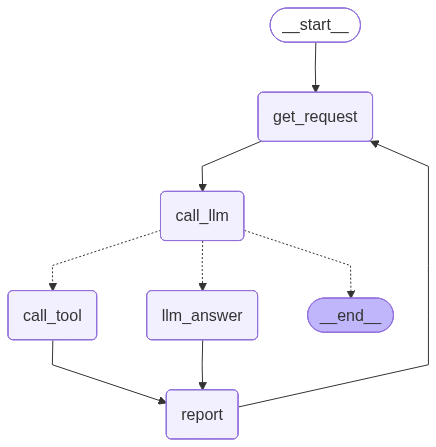

In [90]:
agent.get_application()

## Execution

In [91]:
agent()

----------------------------------------------------------------------------------------------------


What do you need? (Type 'exit' to stop):  What is the most famouse movie in iMDB


Source: The most Famous films of all time? - movies - Reddit
URL: https://www.reddit.com/r/movies/comments/18flayi/the_most_famous_films_of_all_time/
Content: Avengers Endgame by FAR the most famous for anyone living on the planet today. Avatar. Titanic. Star Wars. Nothing else would even come close.
---

----------------------------------------------------------------------------------------------------


What do you need? (Type 'exit' to stop):  exit
